# HW4: Bias and GANs


Designed by Maan Qraitem drawing from prior work by Anil Kag, Samarth Mishra, Kun He, Xide Xia, Kubra Cilingir, Vijay Thakkar, Ali Siahkamari, and Brian Kulis.


This assignment will introduce you to 

1. Understanding Spurious Bias and its impact on Model Performance [40 points]

2. Implementing Domain-Independance: A method to mitigate Spurious Bias [40 Points]

3. Introduce Generative Adversarial Learning building blocks. [40 points]

4. Use above blocks to change hairstyles of popular celebrities available in the CelebA dataset. [60 points]

**NOTE** : Problem 3 and 4 are time consuming, not just from code perspective but it takes some effort in training to get reasonable GAN performance (you should expect the training to take roughly 10 hours or more depending on the complexity you choose), so **PLEASE START EARLY.**

## Preamble

We recommend using GPU as the primary compute for these problems. For the first two tasks, we do not expect you to require too much GPU compute time (efficient code should finish within 20mins on a GPU like K80). For the GAN problems, we expect longer run time (specially the problem 4 should take more than 6 hours to get a reasonable generator).

## Environment setup

We provide you the datasets required for this assignment as shared folders in both SCC (`'/projectnb/dl523/students/mqraitem/datasets/'`) and [Google Drive](https://drive.google.com/drive/folders/1EFJKm8mZk6GPrN2BRuadL_HRg0STb7V0?usp=sharing).


Below we describe the environment setup steps depending on your preferrence. Through [(SCC)](https://www.bu.edu/tech/support/research/computing-resources/scc/) you can get access to GPU compute, below we describe the steps for setting up a tunnel so that you can open a Jupyter notebook on your end.

If you intend to use Google colab, feel free to skip the below steps. Remember, Google colab only provides you a preemptive access to a GPU, so technically you could loose access to a GPU in the middle of your experiments. Ideally, it will allow you access to a GPU for 12 hours (free quota). Also, since its a shared resource, be respectful of the Google colab usage policy. 

## SCC Configuration

For this assignment, we recommend that you use the shared computing cluster [(SCC)](https://www.bu.edu/tech/support/research/computing-resources/scc/). Each of you has an account on the SCC and can login using (more info on the [quick start guide](https://www.bu.edu/tech/support/research/system-usage/scc-quickstart/)):
```
ssh <bu_loginname>@scc1.bu.edu
```

[comment]: #   ( Copy `HW4_datasets.zip` to the SCC, extract and change working directory to the extracted folder. )

Here, we provide some instructions to start a jupyter notebook or jupyter lab server on the SCC. More detailed instructions can be found on the SCC's info website (linked above). These instructions are also fairly easy to find with a google search.
You can then request an interactive session on a compute node using:
```
qrsh -pe omp <num_cpu_cores> -l gpus=<num_gpus_per_cpu_core> -l gpu_c=<gpu_compute_capacity>
```
Recommended values for the parameters in <> above are 2, 1 and 3.5 repectively, which will assign you 2 cpu cores, 1 gpu of compute capacity at least 3.5 for an interactive session of 12 hours. We also have access to some GPUs with compute capacity 6.0 (but they may be somewhat limited in numbers), if you want to explore these GPUs, feel free to request with gpu_c=6.0. 

Now that you are on a compute node, you can load modules you need as:
```
module load cuda/10.1
module load python3/3.6.9
module load pytorch/1.3
```
Running a jupyter server (you can replace the following with `jupyter notebook` for the old interface):
```
jupyter lab --no-browser --ip=0.0.0.0 --port=8888
```
To access the jupyter interface on a browser on your personal machine, use ssh port forwarding as,
```
ssh -N -f -L 8889:<scc-compute-node>:8888 <bu_loginname>@scc1.bu.edu
```
where `<scc_compute_node>` is the compute node on the scc that you have access to through your interactive session (e.g. `scc-k02`). Open a browser and the interface should be accessible at `localhost:8889`. The ports `8888` and `8889` can be changed for something else. If these ports are already in use, feel free to use unused port numbers in the above command.

### Assignment Shared Data path

If you are using your local machine or SSC, please update the python variable `EXPERIMENTS_DIRECTORY` and `DATA_DIR`, prepopulated below to the correct folder where you have stored the files provided for this assignment.

Note that 
1. `EXPERIMENTS_DIRECTORY` : refers to the folder where your experiment results, models, logs and the sample generated will be stored. Please update the path to a folder you have write access. For SCC, it is recommended that you create a folder, ` '/projectnb/ec523/<USER-NAME>/experiments'`, change `<USER-NAME>` to your scc username. For Google colab, use any folder you have write access.

2. `DATA_DIR` : refers to the folder where the datasets required for this assignment are stored (For scc, I've already copied the datasets to a folder ( `'/projectnb/dl523/students/mqraitem/datasets/'` ) where everyone has read accesss. For Google colab, I've shared the dataset at the following directory, `https://drive.google.com/drive/folders/1EFJKm8mZk6GPrN2BRuadL_HRg0STb7V0?usp=sharing`, please update this variable according the path that your BU Google drive account shows. )

## Google Colab Configuration

No special setup is required (just ensure that the runtime is setup to utilize a GPU).

### Assignment Shared Data path

If you are using Google Colab for the experiments, it is easy to link your BU google drive account for storage purposes.

1. First step is to give access permissions to the google colab. Following commands perform the authentication (run these two lines of code, it'll provide you the link for authentication, copy & paste the authorization code in the fill in box provided by the script.)
```
from google.colab import drive
drive.mount('/content/gdrive')
```

2. Finding the right folder path for experiments. Similar to the ```ls``` command in linux, the following command lists the content of the drive (use this to choose your base experiment directory)
```
ls "/content/gdrive/My Drive"
```

3. Please copy all the data provided for this assignment  to the experiment directory, say in the location ```"/content/gdrive/My Drive/Experiments-Deep-Learning-HW4"``` (If you change the path, please update the same in the script below.)
```
ls "/content/gdrive/My Drive/Experiments-Deep-Learning-HW4"
```


In [1]:
# Change this part to locate the correct directory where dataset resides
use_colab = False

if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    #!ls "/content/gdrive/My Drive/Datasets/shared/HW4_shared_files"

    ## Update the experiments directory
    EXPERIMENTS_DIRECTORY = '/content/gdrive/My Drive/Datasets/shared/experiments/'
    DATA_DIRECTORY = '/content/gdrive/My Drive/Datasets/shared/HW4_shared_files/'
    CELEBA_GOOGLE_DRIVE_PATH = DATA_DIRECTORY + 'celeba_attributes_images.hdf5'
    IMDB_REVIEWS_FILE_PATH = DATA_DIRECTORY + 'data/'
else:
    ## Update the experiments directory
    EXPERIMENTS_DIRECTORY = '/projectnb/dl523/students/buzjhcs/experiments'
    DATA_DIRECTORY = '/projectnb/dl523/materials/datasets/'
    CELEBA_GOOGLE_DRIVE_PATH = DATA_DIRECTORY + 'celeba_attributes_images.hdf5'
    IMDB_REVIEWS_FILE_PATH = DATA_DIRECTORY + 'data/'


### Modules needed

### Modules needed

In [2]:
import os
import random
import math
import datetime
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils import data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.backends import cudnn

import numpy as np 
from PIL import Image
from IPython.display import clear_output, Image as displayImage, display

from tqdm import tqdm 
import random 

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch import nn, optim


%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Q1.1 : Survery of Bias in Deep Learning [10 Points]

Bias in Deep Learning can manifest in many ways. Start by reading the following [Survey](https://arxiv.org/pdf/1908.08843.pdf) . Upon reading, please answer the questions below: 


1. Given a sensitive group of samples (eg a certain class of people), can a deep learning model learn to discriminate against said group if we do not explicitly feed identifying information to the model (ex class indicator variable, zip code, etc)? Support your argument with an example. 

2. what is the disadvantage of post-processing methods that calibrate prediction scores to fit a certain fairness metric? discuss this disadvantage in the context of deep learning applications. 

 

 **Insert you answer here**: 
## 1. Answer:
Yes, deep learning model will learn to discriminate. In the paper, three classes of Discrimination are shown for us.

### 1. Discrimination via Input
1. In STEM jobs Employment case: Recruiting tool believes that men are more qualified and shows bias against women.
2. In Criminal Justice: Recidivism prediction system predicts black inmates are three times more likely to be classified as ‘high risk’ than white inmates.

### 2. Discrimination via Representation
1. Medical Image Diagnosis: CNN model could identify patients’ self-reported sex from a retina image, and shows discrimination based on gender.
2. Credit Scoring: Using raw texts as input, demographic information of authors is encoded in the intermediate representations DNN-based credit scoring classifiers.

### 3. Prediction Quality Disparity
1. Facial Recognition: Facial recognition performs very poorly for female with darker skin.
2. Language processing: Language identification models perform significantly worse when processing text produced by people belonging to certain races.
3. Readmission: ICU mortality and psychiatric 30-day readmission model prediction accuracy is significantly different across gender and insurance types.

## 2. Answer:
Disadvantage: This method could be problematic since it requires inference-time access to protected attributes, which however usually are not available during inference time in real-world applications.

In this problem, we will study one form of Bias, usually called: Spurious Correlations. We will explore this bias implication on model performance using a visual recognition problem *. More concretely, given a standard visual recognition dataset with image-target pairs $(X, Y)$ assume that each $x\in X$ can also be classified into a sensitive group $b \in B$. For example, $B$ can represent the various colors of an object or the material it is made of. Bias research is concerned with the scenario when most samples of one class (e.g., airplane) belong to one sensitive group (e.g., objects with the color red). Therefore, the model might use this signal (most airplanes are red) in predicting airplanes. This means the model might be less likely to predict an airplane if it was of the color blue. If your goal for your model is to recognize airplanes of all colors equally well, then the behavior above is suboptimal. 

In this problem, we will use the CIFAR10 dataset to document the occurrence of such Bias. Then, we will experiment with a simple baseline that mitigates it. 

\* Note that this form of Bias can affect more than visual recognition. Examples include Image captioning, VQA, and others.

In [3]:
class BiasedCifar10: 
    def __init__(self, root, split, skew_value=0.5): 
        train_valid = (split == 'train' or split == 'valid')
        self.cifar10 = CIFAR10(root, train=train_valid, download=True)
        self.images = self.cifar10.data 
        self.targets = np.array(self.cifar10.targets) 
        self.bias = np.zeros_like(self.targets) 
        self.split = split
        self.gray_classes =  [0,1,2,3,4]


        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2470, 0.2435, 0.2616]
        self.transform =  transforms.Compose([
                          transforms.ToPILImage(), 
                          transforms.RandomCrop(32, padding=4),
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize(mean, std)])

        if train_valid: 
            self.build_split() 
            self.corrupt_dataset(skew_value)    

        else: 
            self.corrupt_dataset(0.5)
                          
    def build_split(self):
        
        indices = {i:[] for i in range(10)} 
        size_per_class = 5000
        for idx, tar in enumerate(self.targets): 
            indices[tar].append(idx)

        if self.split == 'train': 
            start = 0 
            end = int(size_per_class * 0.9) 

        if self.split == 'valid':
            start = int(size_per_class * 0.9) 
            end = size_per_class

        final_indices = [] 
        for ind_group in indices.values(): 
            final_indices.extend(ind_group[start:end]) 
        
        random.shuffle(final_indices) 
        
        self.images = self.images[final_indices]
        self.bias = self.bias[final_indices]
        self.targets = self.targets[final_indices] 
        
    def rgb_to_grayscale(self, img):
        """Convert image to gray scale"""
        
        pil_img = Image.fromarray(img)
        pil_gray_img = pil_img.convert('L')
        np_gray_img = np.array(pil_gray_img, dtype=np.uint8)
        np_gray_img = np.dstack([np_gray_img, np_gray_img, np_gray_img])
    
        return np_gray_img

    def corrupt_dataset(self, skew_level):
        
        samples_by_class = {i:[] for i in range(10)} 
        for idx, target in enumerate(self.targets): 
            samples_by_class[target].append(idx) 

        for class_idx in tqdm(range(10)): 
            class_samples = samples_by_class[class_idx]
            if class_idx in self.gray_classes: 
                samples_skew_num = int(len(class_samples) * skew_level) 
            else: 
                samples_skew_num = int(len(class_samples) * (1 - skew_level)) 
                
            samples_skew = random.sample(class_samples, samples_skew_num)
            for sample_idx in samples_skew: 
                self.images[sample_idx] = self.rgb_to_grayscale(self.images[sample_idx]) 
                self.bias[sample_idx] = 1 
    
    def __len__(self): 
        return len(self.images) 

    def __getitem__(self, index): 
        img = self.images[index]
        target = self.targets[index]
        bias = self.bias[index]
    
        if self.transform: 
            img = self.transform(img)
        
        return img, target, bias

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch 

from torchvision.models import resnet18


class FCResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        model = resnet18(pretrained=False)
        modules = list(model.children())[:-1]
        self.extractor = nn.Sequential(*modules)
        self.embed_size = 512
        self.num_classes = num_classes
        self.fc = nn.Linear(self.embed_size, num_classes)

    def forward(self, x):
        out = self.extractor(x)
        out = out.squeeze(-1).squeeze(-1)

        logits = self.fc(out)
        return logits

In [9]:
skew_value = 0.9
batch_size = 128

ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value) 
ds_val = BiasedCifar10(root='./', split='valid', skew_value=skew_value) 
ds_test = BiasedCifar10(root='./', split='test') 


train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)


Files already downloaded and verified


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Files already downloaded and verified


100%|██████████| 10/10 [00:00<00:00, 63.45it/s]


Files already downloaded and verified


100%|██████████| 10/10 [00:00<00:00, 32.67it/s]


 As discussed earlier, we will work with CIFAR10 dataset. The dataset comes equipped with 10 classes. The dataset code above introduces bias by converting a $S\%$ of the images in the first 5 classes to Gray-Scale. For the rest of the 5 classes, it will convert $1 - S\%$ of them to Gray-Scale. Assuming $S > 50\%$, the first 5 classes will be biased toward Gray, and the rest will be biased toward Color. Thus, $B = \{\text{Color}, \text{Gray-Scale}\}$. You can control the variable $S$ through the skew_value above. To get you started, run the training code below.

In [6]:
model = FCResNet18(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
decay_epochs = [10, 15, 20]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum =0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

Epochs = 25

for epoch in range(1, Epochs + 1):
    model.train()

    train_iter = iter(train_loader)
    loss_acc = 0 
    for idx, (images, labels, biases) in enumerate(train_iter):
        labels, biases = labels.cuda(), biases.cuda()

        images = images.cuda()
        logits = model(images)

        loss = criterion(logits, labels)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_acc /= Epochs
    print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))

Epoch 1: Loss = 28.95
Epoch 2: Loss = 19.57
Epoch 3: Loss = 17.18
Epoch 4: Loss = 15.42
Epoch 5: Loss = 14.06
Epoch 6: Loss = 13.24
Epoch 7: Loss = 12.57
Epoch 8: Loss = 12.01
Epoch 9: Loss = 11.64
Epoch 10: Loss = 11.26
Epoch 11: Loss = 11.04
Epoch 12: Loss = 10.81
Epoch 13: Loss = 10.69
Epoch 14: Loss = 10.54
Epoch 15: Loss = 10.42
Epoch 16: Loss = 10.19
Epoch 17: Loss = 9.99
Epoch 18: Loss = 10.11
Epoch 19: Loss = 9.80
Epoch 20: Loss = 9.73
Epoch 21: Loss = 9.67
Epoch 22: Loss = 9.64
Epoch 23: Loss = 9.62
Epoch 24: Loss = 9.53
Epoch 25: Loss = 9.46


 As you might have noticed, we only introduce bias to the training set. Therefore, our test set is equally distributed among the bias groups. This choice is because we want to test our model's predictive ability on every bias group. To that end, we will use two metrics. The first one is a standard accuracy metric. The second one is called True Positive Rate Disparity. It seeks to measure the average difference in TPR between the two bias groups for each class. More concretely, it measures: 

$$TD = \frac{1}{C} \sum_{y} | P(\hat{y}=1 | b = 1, y = 1) - P(\hat{y}=1 | b = 0, y = 1)|$$

 Where $C$ indicates the number of classes, $\hat{y}$ indicates model prediction, and $y$ denotes ground-truth label.




### Q1.2 Now, please answer the following questions [10 Points]

1. Why do you think TPR disparity is a good metric to track bias? 

2. what do you think will happen to the Accuracy metric if our test set was not balanced among the bias groups? ie it followed the distribution of the training set

**Insert your answer here:**
### 1. 
1. If TPR disparity is not working for bias track, which means $P(\hat{y}=1 | b = 1, y = 1) - P(\hat{y}=1 | b = 0, y = 1) = 0$ 
But now we really get TPR disparity is not 0. Therefore, this indicates that we have recongnize $b=1$ and $b=0$. We can conclude that TPR disparity is a good metric.

2. TPR tells us how frequently a class gets postive result that is ture. So changing in TPR can be a good metric for presence of bias. 

### 2.
The Accuracy will increase because the model will learn to predict based in the distribution of training set, which features are not that meaningful. Therefore, if we test it on the same distribution will have a higher accuracy

### Q1.3: Finish the test loop below by writing code to compute accuracy and TPR disparity [10 Points]

In [11]:
correct = np.zeros((10, 2)) 
counts = np.zeros((10, 2))

with torch.no_grad():
    for idx, (images, labels, biases) in enumerate(test_loader):
        images, labels, biases = images.cuda(), labels.cuda(), biases.cuda()
        output = model(images).cpu()
        preds = output.data.max(1, keepdim=True)[1].squeeze(1).cuda()
#         labels = labels.cpu()
#         labels.numpy()
    ################################################
    ##### TODO CODE HERE
        for i in range(len(labels)):
            y,y_pred = labels[i].item(),preds[i].item()
            match = int(y==y_pred)
            if biases[i].item():
                correct[y][0] += match
                counts[y][0] += 1
            else:
                correct[y][1] += match
                counts[y][1] += 1
    ################################################

final = correct/counts
print("Accuracy %.2f "%np.mean(final))
print("TPR Disparity %.2f "%np.mean(np.abs(final[:, 0] - final[:, 1])))

Accuracy 0.64 
TPR Disparity 0.34 


### Q1.4 Repeat the above training procedure three times using $S \in \{0.85, 0.9, 0.95\}$. Record your TPR and Acc values below and run the code to plot your results. what do you conclude? [10 Points]

Text(0, 0.5, 'TPR Disparity')

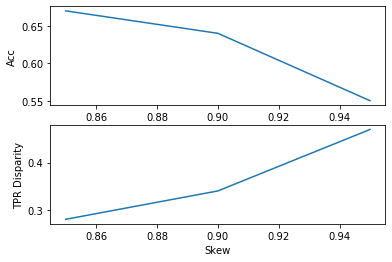

In [12]:
Skew = [0.85, 0.9, 0.95]

################################################
##### FILL YOUR EXPERIMENTS VALUES HERE
Acc = [0.67, 0.64, 0.55]
TPR = [0.28, 0.34, 0.47] 
################################################


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(Skew, Acc)
ax1.set_xlabel('Skew')
ax1.set_ylabel('Acc')

ax2.plot(Skew, TPR)
ax2.set_xlabel('Skew')
ax2.set_ylabel('TPR Disparity')

**Insert your answer here:**
1. When we improve the fairness(TPR Disparity), the Accuracy will decrease.
2. Different fairness will contradict each other.

### Q2 Mitigating Bias 

In this section of the problem, we will explore Domain Independence, one of many solutions for mitigating Bias. The solution dedicates a prediction head for each different sensitive group $b$. Observe the Figure below. Note that each sensitive group: Color/Gray will have its prediction head of 10 classes. Thus, when training, samples that belong to $b= $Color will backpropagate only through the Color prediction head. 


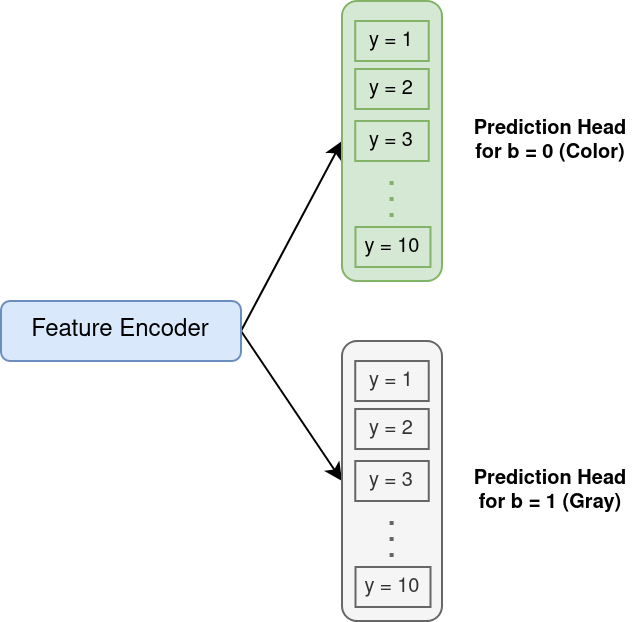

### Q2.1 Why do you think this might be a good solution? [5 Points]

**Insert answer here**

Since color group and gray group have their own 10 classes head prediction. In this situation, color prediction head only focus on color samples and gray prediction head only focus on gray samples. Therefore, each prediction head will learn other meaningful features than color/gray.

### Q2.2: We wrote most of the model structure but we left the final linear layer for you to implement. Fill in the code below: [5 Points]

In [60]:
class DIResNet18(nn.Module):
    def __init__(self, num_classes=10, num_biases=2):
        super().__init__()
        model = resnet18(pretrained=False)
        modules = list(model.children())[:-1]
        self.extractor = nn.Sequential(*modules)
        self.embed_size = 512
        self.num_classes = num_classes

        ################################################
        ##### TODO CODE HERE
        self.fc = nn.Linear(self.embed_size, num_classes * 2)
        ################################################ 
                
    def forward(self, x):
        out = self.extractor(x)
        out = out.squeeze(-1).squeeze(-1)
        logits = self.fc(out)
        return logits

### Q2.3: Before we start training, we need to write the loss function. First, you will need to apply softmax for each head independently. Then, given the bias value for each sample, you will need to select the logit values of that sample from the correct prediction head [20 Points] 

Hint: Consider using Pytorch NLL [implemenation](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html). 

In [61]:
class DILoss(nn.Module):
    def __init__(self, num_classes=10, num_biases=2):
        super().__init__()
        self.num_classes = num_classes
        self.num_biases = num_biases

    def forward(self, logits, labels, biases):
        ################################################
        ##### TODO CODE HERE
        h1 = F.log_softmax(logits[:, :self.num_classes], dim = 1)
        h2 = F.log_softmax(logits[:, self.num_classes: ], dim = 1)
        output = torch.zeros(len(logits), self.num_classes)
        for i in range(len(logits)):
            if biases[i] == 0:
                output[i] = h1[i]
                
            else:
                output[i] = h2[i]
        loss = F.nll_loss(output.cuda(), labels)
        ################################################ 
        return loss

### Once you are done with the loss, you can start training the model below. 

In [62]:
skew_value = 0.95
batch_size = 128

ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value) 
ds_val = BiasedCifar10(root='./', split='valid', skew_value=skew_value) 
ds_test = BiasedCifar10(root='./', split='test') 


train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

Files already downloaded and verified


100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


Files already downloaded and verified


100%|██████████| 10/10 [00:00<00:00, 68.42it/s]


Files already downloaded and verified


100%|██████████| 10/10 [00:00<00:00, 32.57it/s]


In [63]:
model = DIResNet18().cuda()
criterion = DILoss()
decay_epochs = [10, 15, 20]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum =0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

Epochs = 25

for epoch in range(1, Epochs + 1):
    model.train()

    train_iter = iter(train_loader)
    loss_acc = 0 
    for idx, (images, labels, biases) in enumerate(train_iter):
        labels, biases = labels.cuda(), biases.cuda()

        images = images.cuda()
        logits = model(images)

        loss = criterion(logits, labels, biases)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_acc /= Epochs
    print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))

Epoch 1: Loss = 23.61
Epoch 2: Loss = 16.63
Epoch 3: Loss = 14.53
Epoch 4: Loss = 13.15
Epoch 5: Loss = 12.05
Epoch 6: Loss = 11.46
Epoch 7: Loss = 10.93
Epoch 8: Loss = 10.50
Epoch 9: Loss = 10.08
Epoch 10: Loss = 9.89
Epoch 11: Loss = 9.64
Epoch 12: Loss = 9.49
Epoch 13: Loss = 9.26
Epoch 14: Loss = 9.08
Epoch 15: Loss = 9.00
Epoch 16: Loss = 8.79
Epoch 17: Loss = 8.79
Epoch 18: Loss = 8.75
Epoch 19: Loss = 8.62
Epoch 20: Loss = 8.55
Epoch 21: Loss = 8.53
Epoch 22: Loss = 8.42
Epoch 23: Loss = 8.41
Epoch 24: Loss = 8.35
Epoch 25: Loss = 8.22


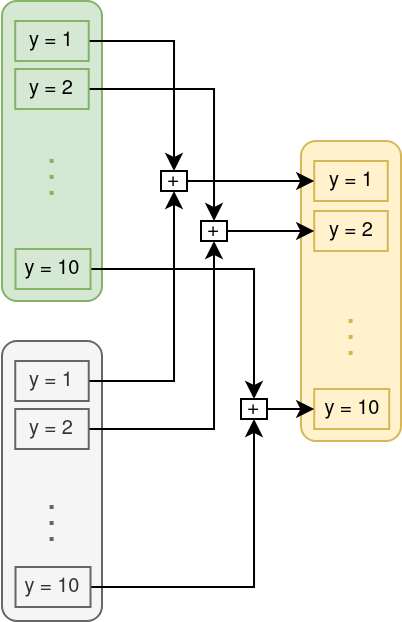

Finally, we will have to do some inference! A significant challenge with this problem is that we don't have access to the bias label at test time. Therefore, we will have to combine the information from each head. It turns out that summing the logits for each class from every head is a good solution, as the figure above suggests. 

### Q2.4: Imeplemnt the inference procedure described above. Have your Unbiased Accuracy and TPR Disparity Improve? [10 Points] 

In [65]:
correct = np.zeros((10, 2)) 
counts = np.zeros((10, 2))

with torch.no_grad():
    ################################################
    ##### TODO CODE HERE
    for idx, (images, labels, biases) in enumerate(test_loader):
        images, labels, biases = images.cuda(), labels.cuda(), biases.cuda()
        logits = model(images).cpu()
        output = logits[:,:10] + logits[:,10:]
        preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

        for i in range(len(labels)):
            if preds[i]==labels[i]:
                correct[labels[i],biases[i]]+=1
            counts[labels[i],biases[i]]+=1
            
#             y,y_pred = labels[i].item(),preds[i].item()
#             match = int(y==y_pred)
#             if biases[i].item():
#                 correct[y][0] += match
#                 counts[y][0] += 1
#             else:
#                 correct[y][1] += match
#                 counts[y][1] += 1 this is not work in 2.4
    ################################################

final = correct/counts
print("Accuracy %.2f "% np.mean(final))
print("TPR Disparity %.2f "%np.mean(np.abs(final[:, 0] - final[:, 1])))

Accuracy 0.68 
TPR Disparity 0.06 


Yes, Unbiased Accuracy and TPR Disparity has improved. Accuracy increase from 0.55 to 0.68, and TPR decrease from 0.47 to 0.06

## Q3 : GAN model on Celeb-A face dataset [40 points]

We will implement a Generative Adversarial Network (GAN) in Q3 and Q4. In this problem, we will start by implementing basic helper functions and a working training routine which would be modified a bit in problem Q4 to present a hairstyle change application. 

This assignment is inspired by the following research paper, 

[StarGAN: Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation](https://arxiv.org/abs/1711.09020)

Note that the basic building blocks of GAN are 
1. **Generator** : generates images similar to the real images provided in the dataset in order to fool the discriminator.

2. **Discriminator** : acts as a fact checker in order to determine which images are fake and which are real 

3. **Latent representation** : generator cannot arbitrarily generate images out of thin air. It picks up a latent representation (usually a noise or some fixed pattern), and utilizes this source as a latent code and generates image during this process.

For an easy tutorial to understand GAN's building blocks, please follow the PyTorch DC-GAN [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). It is recommended you study the tutorial before proceeding with the assignment. 


Note that f and g in the following image are the same as $D$ and $G$ respectively

<img src="https://i.imgur.com/FhSycJD.png" style="width: 600px;"/>

Although the tutorial describes the GAN framework very well with appropriate links to the original paper, for completeness, we mention the losses for the discriminator and generator. The GAN optimization objective is the following : 

$$\underset{G}{\text{min}} ~~ \underset{D}{\text{max}} ~~ V(D,G) = \mathbb{E}_{x\sim p_{x}(x)}\big[\log D(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[\log (1-D(G(z)))\big]$$

where $p_{x}(x)$ is the distribution of the real image data and $p_{z}(z)$ is the distribution from which latent vectors are sampled to input to the generator. $G$ is the generator, parametrized by parameters $w$ and $D$, the discriminator with parameters $\phi$. In practice, these parameters are usually optimized in an alternating fashion, fixing one when optimizing the other, with the following loss functions:

$$ loss_D(\phi) = - \mathbb{E}_{x\sim p_{x}(x)}\big[\log D(x; \phi)\big] - \mathbb{E}_{z\sim p_{z}(z)}\big[\log (1-D(G(z; w); \phi))\big] $$

$$ loss_G(w) = - \mathbb{E}_{z\sim p_{z}(z)}\big[\log (D(G(z; w); \phi))\big] $$

In this assignment you shall use these loss functions and method of training $G$ and $D$.

## StarGAN Architecture (Single dataset)

Above figure is a generic representation of a DC-GAN architecture, although powerful, it will not be able to accuractly generate discrete feature transformations. Instead we use StarGAN, originally proposed to learn feature generators using multiple dataset (uses two large vision datasets (CelebA, RaFD) in the paper). For example in the image below, you see the entire architecture which uses only CelebA dataset, and keeps discards RaFD information. For simplicity, we will use only one dataset, i.e. CelebA. From this architecture, you should takeaway the following points

1. **Discriminator** is learning to distinguish between a real and a fake/generator image. It also learns what the label looked like in the original dataset (we only care about CelebA label).

2. **Generator** is learning to generate a new image from the given input image and the target attribute (for example hairstyle change, in the image below, gender change is requested). 

Note that the attribute or the latent information for the generator is a discrete boolean vector, instead of a Gaussian vector which you generate in GANs like DC-GAN. 

<img src="https://i.imgur.com/58dbEX9.png" style="width: 600px;"/>


### Arguments

First, we first define some arguments for the training run. 

-  **selected_attributes** -  the attributes which will be used for generating various style attributes on the celebrity face.
-  **c_dim** - the number of attributes we will use from the CelebA dataset. its set to `len(selected_attributes)`
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. 
-  **g_conv_dim** - the number of convolutional fitlers for generator
-  **d_conv_dim** - the number of convolutional fitlers for discriminator 
-  **g_repeat_num** - the number of residual blocks in the generator 
-  **d_repeat_num** - the number of residual blocks in the discriminator
-  **lambda_cls** - the regularization hyper-parameter for classification error
-  **lambda_rec** -  the regularization hyper-parameter for reconstruction error
-  **lambda_gp** -  the regularization hyper-parameter for gradient penalty

-  **batch_size** - the batch size used in training. The paper
   uses a batch size of 16 for large configuration
-  **num_iters** - the number of training iterations
   the DataLoader
-  **num_iters_decay** - the number of iterations after which learning rate will decay
-  **g_lr** - the learning rate for generator
-  **d_lr** - the learning rate for discriminator
-  **n_critic** - generator will be updated every n_critic iterations.
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **beta2** - beta2 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.999
-  **num_workers** - the number of worker threads for loading the data with
   the DataLoader
-  **log_step** - log the update every log_steps
-  **sample_step** - generate a new sample every sample_step
-  **model_save_step** - save the model every model_save_step
-  **lr_update_step** - update the learning rate every lr_update_step
-  **log_dir** - directory where logs are stored
-  **sample_dir** - directory where samples are stored
-  **model_save_dir** - directory where trained models are stored
-  **result_dir** - directory where results are stored



In [30]:
cudnn.benchmark = True

def get_experiment_configuration(repeat_num=6, num_iters=200000,
              log_step=100, sample_step=100, model_save_step=10000, 
              lr_update_step=1000, batch_size=16, mode='train', resume_iters=False,
              selected_attributes = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']):
    config = {}

    # Model configurations.
    config['c_dim'] = len(selected_attributes)
    config['image_size'] = 64
    config['g_conv_dim'] = 64
    config['d_conv_dim'] = 64
    config['g_repeat_num'] = repeat_num
    config['d_repeat_num'] = repeat_num
    config['lambda_cls'] = 1
    config['lambda_rec'] = 10
    config['lambda_gp'] = 10
    config['selected_attributes'] = selected_attributes 

    # Training configurations.
    config['batch_size'] = batch_size #16
    config['num_iters'] = num_iters
    config['num_iters_decay'] = num_iters//2
    config['g_lr'] = 0.0001
    config['d_lr'] = 0.0001
    config['n_critic'] = 5
    config['beta1'] = 0.5
    config['beta2'] = 0.999
    config['resume_iters'] = resume_iters

    # Test configurations.
    config['test_iters'] = num_iters

    # Miscellaneous.
    config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config['num_workers'] = 1
    config['mode'] = mode

    # Step size.
    config['log_step'] = log_step #10
    config['sample_step'] = sample_step
    config['model_save_step'] =  model_save_step #10000
    config['lr_update_step'] = lr_update_step # 1000

    EXPERIMENT_RESULTS_FOLDER = EXPERIMENTS_DIRECTORY + 'gan-experiments/'

    suffix = str(repeat_num) + '-cdim-' + str(len(selected_attributes))
    config['log_dir'] = EXPERIMENT_RESULTS_FOLDER + 'logs-' + suffix
    config['sample_dir'] = EXPERIMENT_RESULTS_FOLDER + 'sample_dir-' + suffix
    config['model_save_dir'] = EXPERIMENT_RESULTS_FOLDER + 'model_save_dir-' + suffix
    config['result_dir'] = EXPERIMENT_RESULTS_FOLDER + 'result_dir-' + suffix

    print('\n\nPlease ensure you are using a GPU for computation')
    print('Will be using the following device for computation : ', config['device'])

    # Create directories if not exist.
    if not os.path.exists(config['log_dir']):
        os.makedirs(config['log_dir'])
    if not os.path.exists(config['sample_dir']):
        os.makedirs(config['sample_dir'])
    if not os.path.exists(config['model_save_dir']):
        os.makedirs(config['model_save_dir'])
    if not os.path.exists(config['result_dir']):
        os.makedirs(config['result_dir'])

    return config

### Data

We have downloaded pre-processed and stored data in the HDF5 format on the zip file provided with the assignment. Think of the file storing a large numpy ndarray of images (shape : `num_imgs x num_channels x height x width`). `celebA` class implemented below derives from `torch.utils.data.Dataset` and provides the code infrastucture to read images from this file. 

This data contains images of many celebrities along with labels for various image attributes (hair, gender, age, etc). There are 40 such attributes. We will use them later for cool applications. 

In [31]:
ALL_ATTRIBUTES = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',  
      'Bags_Under_Eyes',  'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 
      'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
      'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
      'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
      'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 
      'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
      'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
      'Wearing_Necklace', 'Wearing_Necktie', 'Young' ]
print('# attributes = ', len(ALL_ATTRIBUTES))

# attributes =  40


The above attributes can help us learn a GAN which can transfer various attributes from the given input image. For example, in the original paper, they show that the input image can be transformed such that many attributes change (hair color, gender, age, skin in this example).
<img src="https://i.imgur.com/eXxK09G.jpg" style="width: 600px;"/> 

In [32]:
class CelebA(torch.utils.data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, transform, mode, config):
        """Initialize and preprocess the CelebA dataset."""

        self.file = h5py.File(CELEBA_GOOGLE_DRIVE_PATH, 'r')
        self.total_num_imgs, self.H, self.W, self.C = self.file['images'].shape

        self.images = self.file['images']
        self.attributes = self.file['attributes']

        self.selected_attrs = config['selected_attributes'] 
        self.all_attr_names = ALL_ATTRIBUTES

        self.transform = transform
        self.mode = mode

        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        for i, attr_name in enumerate(self.all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        self.all_idxs = np.arange(self.total_num_imgs)
        N_test = 9
        self.train_dataset = self.all_idxs[:-N_test] 
        self.test_dataset = self.all_idxs[-N_test:]

        random.seed(1234)
        np.random.seed(1234)        
        np.random.shuffle(self.train_dataset)

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        idx = dataset[index]

        image = self.file['images'][idx]
        attributes = self.file['attributes'][idx]

        label = []
        for attr_name in self.selected_attrs:
            idx = self.attr2idx[attr_name]
            label.append(attributes[idx])
        
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(config, mode='train'):
    """Build and return a data loader."""
    
    batch_size = config['batch_size']
    num_workers = config['num_workers']
    
    transform = []
    transform.append(T.ToPILImage())
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)
    
    dataset = CelebA(transform, mode, config)

    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader
  
def denorm(x):
    """Convert the range from [-1, 1] to [0, 1]."""
    out = (x + 1) / 2
    return out.clamp_(0, 1)



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
Finished preprocessing the CelebA dataset...


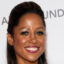

In [33]:
SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

small_config = get_experiment_configuration(repeat_num=1, num_iters=20000,
              batch_size=128, selected_attributes = SELECTED_ATTRIBUTES)

loader = get_loader(small_config, mode='test')
data_iter = iter(loader)
x_fixed, _ = next(data_iter)

from torchvision.transforms import ToPILImage
to_img = ToPILImage()

# display tensor
to_img( denorm( x_fixed[0]  ) )

### Modules for Generator and Discriminator

The following cell defines the generator and discriminator networks as `nn.Modules` .

In [34]:
class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    """Discriminator network."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

Miscellaneous functions for updating learning rates, resetting the gradients and restoring a trained model from storage.

In [35]:
def update_lr(g_optimizer, d_optimizer, g_lr, d_lr):
    """Decay learning rates of the generator and discriminator."""
    for param_group in g_optimizer.param_groups:
        param_group['lr'] = g_lr
    for param_group in d_optimizer.param_groups:
        param_group['lr'] = d_lr

def reset_grad(g_optimizer, d_optimizer):    
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

### Helper Functions

Implement the following helper functions to complete the training code. Follow the instructions in the questions below.



### Q3.1  Print number of parameters in the networks (5 points)

Write a function that takes input as a model and the model name, and prints the model and the number of parameters in the model.


In [36]:
def print_network(model, name):
    num_params = 0

  ################################################
  ##### TODO CODE HERE
    for p in model.parameters():
        num_params += p.numel()
        
    print(name)
    print(model)
  ################################################
    print("The number of parameters: {}".format(num_params))

### Q3.2 Invoke the optimizers on the Generator and Discriminator parameters (5 points)
Write a function that takes optimization parameters as input and returns optimizer functions for the discriminator and generator in PyTorch. Use [ADAM](https://arxiv.org/pdf/1412.6980.pdf) optimizer with the parameters $\beta_1$ and $\beta_2$ specified earlier.

In [37]:
def get_optimizers(G, D, g_learning_rate, d_learning_rate, beta1, beta2):
    """
    Returns a 2-tuple, optimizers for parameters of netD and netG
    """

    ################################################
    ##### TODO CODE HERE
    g_optimizer = torch.optim.Adam(G.parameters(), g_learning_rate, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_learning_rate, [beta1, beta2])
    ################################################

    return g_optimizer, d_optimizer

### Q3.3 Compute classification loss (5 points)

Given the logits and the target labels, compute binary cross entropy loss $\ell_{\text{cls}}$ .

In [38]:
def classification_loss(logit, target):
    """
    Compute binary cross entropy loss.
    """

    loss = 0.0

    ################################################
    ##### TODO CODE HERE
    loss = F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)
    ################################################

    return loss

### Q3.4 Compute reconstruction loss (5 points)

This is a very popular loss function used in situations where you are given an original input $x$. In generative learning, through some latent space, you'll generate an almost replica of $x$, let us denote it by $\hat{x}$.

The reconstruction loss measures the distance between the replica and the original. Let $N$ be the number of elements in $x$ and $\hat{x}$, then the loss can be written as 

$$
\ell_{\text{rec}} =  \frac{1}{N} \sum^N_{i=1} | x_i - \hat{x}_i |
$$

In [39]:
def reconstruction_loss( x_real, x_reconstructed ):
    """
    Compute the reconstruction loss.
    """

    ################################################
    ##### TODO CODE HERE
    loss = torch.mean(torch.abs(x_real - x_reconstructed))
    ################################################

    return loss

### Q3.5 Implement the discriminator loss (5 points)
Write a function that returns the discriminator loss written as :

$$
\ell_{discriminator} = \ell_{real} + \ell_{fake}  +  \lambda_{cls} * \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [40]:
def get_discriminator_loss(G, D, label_org, x_real, c_trg, lambda_cls, lambda_gp):
    """
    """

    out_src, out_cls = D(x_real)
    d_loss_real = -torch.mean(out_src)
    ################################################
    ##### TODO CODE HERE
    ##### classification loss between out_cls, label_org
    d_loss_cls = classification_loss(out_cls, label_org)
    ################################################

    # Compute loss with fake images.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake.detach())
    d_loss_fake = torch.mean(out_src)

    d_loss_gp = torch.tensor(0)

    # Backward and optimize.
    d_loss = d_loss_real + d_loss_fake
    ################################################
    ##### TODO CODE HERE
    ##### add remaining loss terms as described in the problem
    d_loss += lambda_cls * d_loss_cls
    d_loss += lambda_gp * d_loss_gp
    ################################################
    
    return d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp

### Q3.6 Implement the generator loss (5 points)

Write a function that returns the generator loss written as :

$$
\ell_{generator} = \ell_{fake} + \lambda_{rec} * \ell_{rec} +  \lambda_{cls} * \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [41]:
def get_generator_loss(G, D, x_real, c_trg, c_org, label_trg, lambda_rec, lambda_cls):
    """
    """

    # Original-to-target domain.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake)
    g_loss_fake = - torch.mean(out_src)

    ################################################
    ##### TODO CODE HERE
    ##### classification loss between out_cls and label_trg
    g_loss_cls = classification_loss(out_cls, label_trg)
    ################################################

    # Target-to-original domain.
    x_reconst = G(x_fake, c_org)
    ################################################
    ##### TODO CODE HERE
    ##### reconstruction loss between x_real and x_reconst
    g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))
    ################################################

    # Backward and optimize.
    g_loss = g_loss_fake
    ################################################
    ##### TODO CODE HERE
    ##### add remaining loss terms as described in the problem
    g_loss +=   lambda_rec * g_loss_rec 
    g_loss +=   lambda_cls * g_loss_cls
    ################################################

    return g_loss, g_loss_fake, g_loss_cls, g_loss_rec

The following cell initializes the generator and discriminator. Prints both  neural networks, and allocates optimizers.

In [42]:
# Instantiate Generator and Discriminator

SELECTED_ATTRIBUTES = ['Blond_Hair']

config = get_experiment_configuration(repeat_num=3, num_iters=30000, 
              log_step=100, sample_step=1000, model_save_step=1000, 
              batch_size=64, selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])

print_network(G, 'G')
print_network(D, 'D')
    
G = G.to(config['device'])
D = D.to(config['device'])



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
G
Generator(
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [51]:
def create_labels(c_org, c_dim=5, selected_attrs=SELECTED_ATTRIBUTES):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.
    hair_color_indices = []
    for i, attr_name in enumerate(selected_attrs):
        if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
            hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        c_trg = c_org.clone()
        if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
            c_trg[:, i] = 1
            for j in hair_color_indices:
                if j != i:
                    c_trg[:, j] = 0
        else:
            c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

        c_trg_list.append(c_trg.to(config['device']))
    return c_trg_list

# Set data loader.
data_loader = get_loader(config, 'train')
device = config['device']

# Fetch fixed inputs for debugging.
data_iter = iter(data_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)
c_fixed_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

Finished preprocessing the CelebA dataset...


### Q3.7 : Training loop (10 points)
Now, using the functions defined above, implement the main training loop. Some of it has already been done for you. Fill in code where indicated.

Note that your after every `config['sample_step']`, the code generates new samples in the directory indicated in the configuration. Please monitor this to see how your generated images look like.


In [54]:
# Learning rate cache for decaying.
g_lr = config['g_lr']
d_lr = config['d_lr']

# Start training from scratch or resume training.
start_iters = 0

G_losses = []
D_losses = []
cur_g_loss = 0
cur_d_loss = 0

# Start training.
print('Start training...')
start_time = time.time()
for i in range(start_iters, config['num_iters']):
    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    # Fetch real images and labels.
    try:
        x_real, label_org = next(data_iter)
    except:
        data_iter = iter(data_loader)
        x_real, label_org = next(data_iter)

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()

    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original labels.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # Train discriminator
    ################################################
    ##### TODO CODE HERE
    ##### Get the discriminator loss and optimize discriminator
    lambda_cls = config['lambda_cls']
    lambda_gp =  config['lambda_gp']
    lambda_rec = config['lambda_rec']
    d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp = get_discriminator_loss(G, D, label_org, x_real, c_trg, lambda_cls, lambda_gp)
    # Now Optimize discriminator
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    ################################################

    cur_d_loss = d_loss.item()
    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()
    
    # Train the generator                         
    ################################################
    ##### TODO CODE HERE
    ##### Get the generator loss and optimize generator
    g_loss, g_loss_fake, g_loss_cls, g_loss_rec =  get_generator_loss(G, D, x_real, c_trg, c_org, label_trg, lambda_rec, lambda_cls)     
    
    # Now Optimize generator
    ################################################
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    ################################################

    # Logging.
    loss['G/loss_fake'] = g_loss_fake.item()
    loss['G/loss_rec'] = g_loss_rec.item()
    loss['G/loss_cls'] = g_loss_cls.item()
    cur_g_loss = g_loss.item() 

    # Save Losses for plotting later
    G_losses.append(cur_g_loss)
    D_losses.append(cur_d_loss)

    # Print out training information.
    if (i+1) % config['log_step']  == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, config['num_iters'])
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    # Translate fixed images for debugging.
    if (i+1) %  config['sample_step']  == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]
            for c_fixed in c_fixed_list:
                x_fake_list.append(G(x_fixed, c_fixed))
            x_concat = torch.cat(x_fake_list, dim=3)
            sample_path = os.path.join(config['sample_dir'], '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    # Decay learning rates.
    if (i+1) % config['lr_update_step'] == 0 and (i+1) > (config['num_iters'] - config['num_iters_decay']):
        g_lr -= (config['g_lr'] / float(config['num_iters_decay']))
        d_lr -= (config['d_lr'] / float(config['num_iters_decay']))
        update_lr(g_optimizer, d_optimizer, g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

Start training...
Elapsed [0:00:12], Iteration [100/30000], D/loss_real: 0.1870, D/loss_fake: -0.2723, D/loss_cls: 0.1969, D/loss_gp: 0.0000, G/loss_fake: 2.2848, G/loss_rec: 0.1986, G/loss_cls: 0.0284
Elapsed [0:00:24], Iteration [200/30000], D/loss_real: 0.1333, D/loss_fake: -0.1882, D/loss_cls: 0.1598, D/loss_gp: 0.0000, G/loss_fake: 2.0845, G/loss_rec: 0.1566, G/loss_cls: 0.0259
Elapsed [0:00:36], Iteration [300/30000], D/loss_real: 0.1500, D/loss_fake: -0.1814, D/loss_cls: 0.2330, D/loss_gp: 0.0000, G/loss_fake: 1.8644, G/loss_rec: 0.1731, G/loss_cls: 0.0231
Elapsed [0:00:49], Iteration [400/30000], D/loss_real: 0.2139, D/loss_fake: -0.3056, D/loss_cls: 0.1585, D/loss_gp: 0.0000, G/loss_fake: 1.9311, G/loss_rec: 0.1427, G/loss_cls: 0.0210
Elapsed [0:01:01], Iteration [500/30000], D/loss_real: -0.2634, D/loss_fake: 0.2001, D/loss_cls: 0.1659, D/loss_gp: 0.0000, G/loss_fake: 1.2488, G/loss_rec: 0.1414, G/loss_cls: 0.0274
Elapsed [0:01:13], Iteration [600/30000], D/loss_real: 0.1946,

- Plot the generator and discriminator losses. Remember to leave this output intact when you submit the notebook. Not doing so would result in a 2 points penalty.

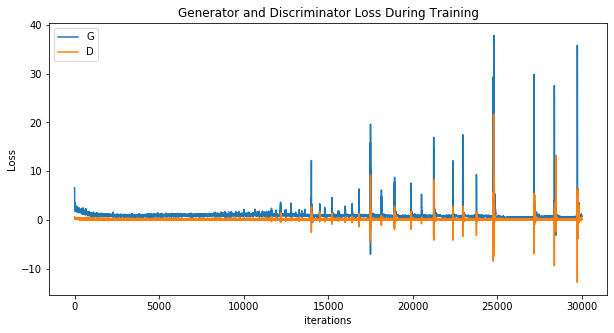

In [55]:
# Losses for 30000

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

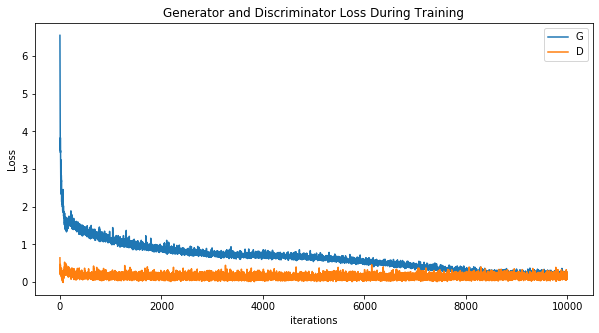

In [54]:
# Losses for 10000
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Results for training 30000
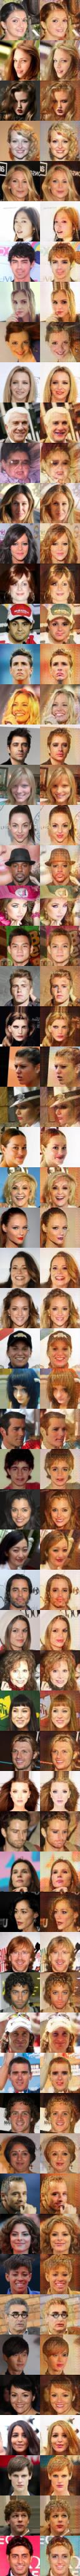

# Results for training 10000
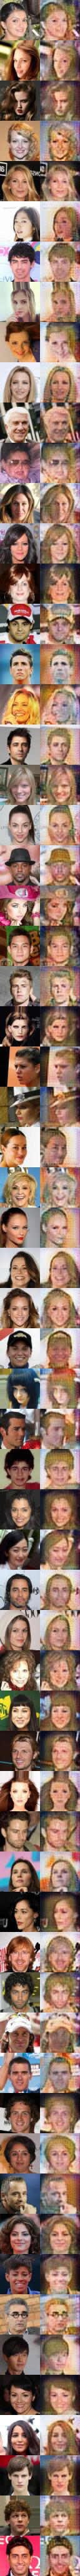

## Conclude
We can see that 30000 is better than 10000, but I'm trying figure out why 30000 loss is bigger than 10000

## Q4: Hair-style transformation [60 points]

In this problem, we will take image and change hair styles as per the trained GAN in the previous step

### Q4.1 : Save trained model (5 points)

We will implement a routine to save the trained generator and discrimantor models, so that we can simply load these later on for inference.

In [44]:
def save_model(G, D, config, step):
    """
    Save the trained generator and discriminator
    """
    model_save_dir = config['model_save_dir']
    G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(step+1))
    D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(step+1))

    ################################################
    ##### TODO CODE HERE
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)
    ################################################
    
    print('Saved model checkpoints into {}...'.format(model_save_dir))


### Q4.2 : Load trained model (5 points)

We will implement a routine to load the trained generator and discrimantor models.

In [45]:
def restore_model(resume_iters, model_save_dir):
    """
    Restore the trained generator and discriminator.
    """

    print('Loading the trained models from step {}...'.format(resume_iters))
    G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(resume_iters))
    D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(resume_iters))

    ################################################
    ##### TODO CODE HERE

    G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
    ################################################

    return G, D

### Q4.3 Implement gradient penalty (10 points)

Given $y = f(x)$, we refer $ \frac{ dy }{ dx } $ as the gradient in this problem. We want to include a gradient penalty in the GAN loss. 
We can write gradient penalty $\ell_{gp}$ as 

$$
\ell_{gp} = \Bigg\|  \Big\| \frac{ dy }{ dx } \Big\|_2 - 1 \Bigg\|^2
$$

(Hint : Using ```grad``` function in the ```torch.autograd``` modules, compute the gradient penalty )

In [46]:
def gradient_penalty(y, x):
    """
    Compute gradient penalty: (L2_norm(dy/dx) - 1)**2.
    """

    ################################################
    ##### TODO CODE HERE
    weight = torch.ones(y.size()).to(config['device']) 
    
    dydx = torch.autograd.grad(outputs=y,
                                   inputs=x,
                                   grad_outputs=weight,
                                   retain_graph=True,
                                   create_graph=True,
                                   only_inputs=True)[0]
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    ################################################

    loss = torch.mean((dydx_l2norm-1)**2)
    return loss

### Q4.4 Implement the discriminator loss (5 points)
Write a function that returns the discriminator loss written as :

$$
\ell_{discriminator} = \ell_{real} + \ell_{fake} + \lambda_{gp} \times \ell_{gp} +  \lambda_{cls} \times \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [47]:


def get_new_discriminator_loss(G, D, label_org, x_real, c_trg, lambda_cls, lambda_gp):
    """
    """

    out_src, out_cls = D(x_real)
    # print(out_src.size(), out_cls.size(),label_org.size())
    #print(out_cls[: , :3])
    # print(config['c_dim'])
    d_loss_real = -torch.mean(out_src)
    ################################################
    ##### TODO CODE HERE
    ##### classification loss between out_cls, label_org
    d_loss_cls = classification_loss(out_cls, label_org)
    ################################################

    # Compute loss with fake images.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake.detach())
    d_loss_fake = torch.mean(out_src)

    # Compute loss for gradient penalty.
    alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
    x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
    out_src, _ = D(x_hat)
    ################################################
    ##### TODO CODE HERE
    ##### gradient penalty on y=out_src, x=x_hat
    d_loss_gp = gradient_penalty(out_src, x_hat)
    ################################################

    # Backward and optimize.
    d_loss = d_loss_real + d_loss_fake
    ################################################
    ##### TODO CODE HERE
    ##### add remaining loss terms as described in the problem
    d_loss += lambda_cls * d_loss_cls 
    d_loss += lambda_gp * d_loss_gp
    ################################################
    
    return d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp
    
    return d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp

### Q4.5 : Initialize a larger GAN using ```get_experiment_configuration``` (10 points)

We will use three hair style attributes in this experiment.

We will train a larger GAN in this problem. First, lets get a larger generator and discriminator models (use more than 3 repeat blocks in the experiment configuration which will increase the number of residual blocks in both the models).

Initialize the generator and discriminator accordingly and get the optimizers.

In [52]:

SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

################################################
##### TODO CODE HERE
config = get_experiment_configuration(repeat_num=3, num_iters=30000, 
              log_step=100, sample_step=1000, model_save_step=1000, 
              batch_size=64, resume_iters=False, selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])
################################################

print_network(G, 'G')
print_network(D, 'D')
    
G = G.to(config['device'])
D = D.to(config['device'])



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
G
Generator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

### Q4.6 : Train the larger GAN (15 points)

At the heart of a GAN network is a minimax problem. Earlier we were optimizing the Generator and the Discriminator at the same speed. 

It turns out that in this case, its recommended that the generator is updated at a slower pace than the discriminator. 

One way to achieve this is to run the generator with smaller learning rate . Instead we want to use the same learning rates as before but we will update the generator every few iterations, i.e. discriminator will be trained in every iteration but the generator will be trained every 5 iterations or more specifically ```config['n_critic']``` number of iterations. Use this recommended value or update as per your intuition.

Note that your after every `config['sample_step']`, the code generates new samples in the directory indicated in the configuration. Please monitor this to see how your generated images look like.

The script also saves your model to the `config['model_save_dir']` every `config['mode_save_step']` so that you can resume training (in case your script crashes after making significant progress) and we can also restore this model when we generate new hairstyles on the test images.

Hopefully your results will be better with these updates.

This will take more than 10 hours to give you reasonable images. So start early.


In [53]:
# Learning rate cache for decaying.
g_lr = config['g_lr']
d_lr = config['d_lr']

# Start training from scratch or resume training.
start_iters = 0
if config['resume_iters']:
    start_iters = config['resume_iters'] 
    G, D = restore_model(config['resume_iters'], config )

G_losses = []
D_losses = []
cur_g_loss = 0
cur_d_loss = 0

# Start training.
print('Start training...')
start_time = time.time()
for i in range(start_iters, config['num_iters']):
    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    # Fetch real images and labels.
    try:
        x_real, label_org = next(data_iter)
    except:
        data_iter = iter(data_loader)
        x_real, label_org = next(data_iter)

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()

    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original labels.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # Train discriminator
    ################################################
    ##### TODO CODE HERE
    lambda_cls = config['lambda_cls']
    lambda_gp =  config['lambda_gp']
    lambda_rec = config['lambda_rec']
    ##### Get the discriminator loss and optimize discriminator
    d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp = get_new_discriminator_loss(G, D, label_org, x_real, c_trg, lambda_cls, lambda_gp)

    # Now Optimize discriminator
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    ################################################

    cur_d_loss = d_loss.item()
    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()
    
    # Train the generator                         
    ################################################
    ##### TODO CODE HERE
    ##### Get the generator loss and optimize generator (every n_critic iterations)
    if (i+1) % config['n_critic'] == 0:
        g_loss, g_loss_fake, g_loss_cls, g_loss_rec =  get_generator_loss(G, D, x_real, c_trg, c_org, label_trg, lambda_rec, lambda_cls)
        # Now Optimize generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        # Logging.
        loss['G/loss_fake'] = g_loss_fake.item()
        loss['G/loss_rec'] = g_loss_rec.item()
        loss['G/loss_cls'] = g_loss_cls.item()
    ################################################
        
    # Print out training information.
    if (i+1) % config['log_step']  == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, config['num_iters'])
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    # Translate fixed images for debugging.
    if (i+1) %  config['sample_step']  == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]
            for c_fixed in c_fixed_list:
                x_fake_list.append(G(x_fixed, c_fixed))
            x_concat = torch.cat(x_fake_list, dim=3)
            sample_path = os.path.join(config['sample_dir'], '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    # Save model checkpoints.
    if (i+1) % config['model_save_step'] == 0:
        save_model(G, D, config, i)

    # Decay learning rates.
    if (i+1) % config['lr_update_step'] == 0 and (i+1) > (config['num_iters'] - config['num_iters_decay']):
        g_lr -= (config['g_lr'] / float(config['num_iters_decay']))
        d_lr -= (config['d_lr'] / float(config['num_iters_decay']))
        update_lr(g_optimizer, d_optimizer, g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

Start training...
Elapsed [0:01:08], Iteration [100/30000], D/loss_real: -0.4227, D/loss_fake: 0.2804, D/loss_cls: 1.2979, D/loss_gp: 0.0021, G/loss_fake: 4.4680, G/loss_rec: 0.3125, G/loss_cls: 1.5655
Elapsed [0:01:16], Iteration [200/30000], D/loss_real: -0.2254, D/loss_fake: 0.0025, D/loss_cls: 0.8615, D/loss_gp: 0.0055, G/loss_fake: 3.4938, G/loss_rec: 0.3077, G/loss_cls: 0.4203
Elapsed [0:01:22], Iteration [300/30000], D/loss_real: -0.1244, D/loss_fake: -0.0645, D/loss_cls: 0.9823, D/loss_gp: 0.0013, G/loss_fake: 2.6377, G/loss_rec: 0.2222, G/loss_cls: 0.3585
Elapsed [0:01:28], Iteration [400/30000], D/loss_real: -0.1614, D/loss_fake: -0.0250, D/loss_cls: 1.0783, D/loss_gp: 0.0017, G/loss_fake: 2.4050, G/loss_rec: 0.2212, G/loss_cls: 0.1765
Elapsed [0:01:34], Iteration [500/30000], D/loss_real: -0.2875, D/loss_fake: 0.1732, D/loss_cls: 0.8699, D/loss_gp: 0.0011, G/loss_fake: 2.4624, G/loss_rec: 0.2497, G/loss_cls: 0.1388
Elapsed [0:01:40], Iteration [600/30000], D/loss_real: -0.13

### Q4.7 : Generate new hairstyles for test images (10 points)

We will apply the hairstyle transformations through the trained Generator model.
We will restore the already trained model, load the test data and invoke the Generator with various hairstyle attributes.

You should expect the output to look like the following image.

<img src="https://i.imgur.com/gbNzQk8.jpg" style="width: 600px;"/>

Loading the trained models from step 30000...
Finished preprocessing the CelebA dataset...
Saved real and fake images into /projectnb/dl523/students/buzjhcs/experimentsgan-experiments/result_dir-3-cdim-3/1-images.jpg...


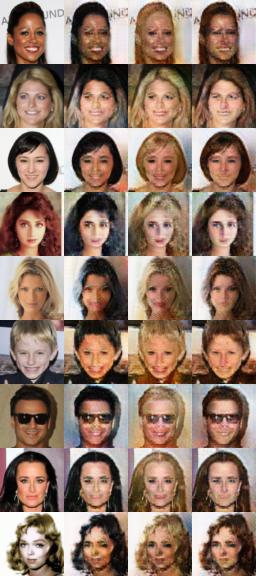

In [37]:
from IPython.display import Image, display

# Choose the iteration number of the saved model (both G, D should be present)
################################################
##### TODO CODE HERE
##### Load the trained model
##### Also, load the data_loader in test mode
G, D = restore_model(30000, config['model_save_dir'])
data_loader = get_loader(config, 'test')

################################################

with torch.no_grad():
    for i, (x_real, c_org) in enumerate(data_loader):

        # Prepare input images and target domain labels.
        x_real = x_real.to(config['device'])
        c_trg_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

        # Translate images.
        x_fake_list = [x_real]
        for c_trg in c_trg_list:
            x_fake = G(x_real, c_trg)
            x_fake_list.append(x_fake)

        # Save the translated images.
        x_concat = torch.cat(x_fake_list, dim=3)
        result_path = os.path.join( config['result_dir'], '{}-images.jpg'.format(i+1) )
        save_image(denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
        print('Saved real and fake images into {}...'.format(result_path))
        display(Image(filename=result_path))

### Q4.8 : (Bonus) Use other attributes and develop something cool. (20 points)

We have seen how to change hair style using GANs so far, but its possible to use any other attributes and develop something much cooler. You can use any other loss functions or the generator/discriminator architecture. Feel free to be creative and develop something cooler. 

In [66]:

SELECTED_ATTRIBUTES = ['Wearing_Hat', 'Pale_Skin', 'Young']

################################################
##### TODO CODE HERE
config = get_experiment_configuration(repeat_num=6, num_iters=30000, 
              log_step=100, sample_step=1000, model_save_step=1000, 
              batch_size=64, resume_iters=False, selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])
################################################

print_network(G, 'G')
print_network(D, 'D')
    
G = G.to(config['device'])
D = D.to(config['device'])



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
G
Generator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [67]:
# Learning rate cache for decaying.
g_lr = config['g_lr']
d_lr = config['d_lr']

# Start training from scratch or resume training.
start_iters = 0
if config['resume_iters']:
    start_iters = config['resume_iters'] 
    G, D = restore_model(config['resume_iters'], config )

G_losses = []
D_losses = []
cur_g_loss = 0
cur_d_loss = 0

# Start training.
print('Start training...')
start_time = time.time()
for i in range(start_iters, config['num_iters']):
    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    # Fetch real images and labels.
    try:
        x_real, label_org = next(data_iter)
    except:
        data_iter = iter(data_loader)
        x_real, label_org = next(data_iter)

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()

    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original labels.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # Train discriminator
    ################################################
    ##### TODO CODE HERE
    lambda_cls = config['lambda_cls']
    lambda_gp =  config['lambda_gp']
    lambda_rec = config['lambda_rec']
    ##### Get the discriminator loss and optimize discriminator
    d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp = get_new_discriminator_loss(G, D, label_org, x_real, c_trg, lambda_cls, lambda_gp)

    # Now Optimize discriminator
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    ################################################

    cur_d_loss = d_loss.item()
    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()
    
    # Train the generator                         
    ################################################
    ##### TODO CODE HERE
    ##### Get the generator loss and optimize generator (every n_critic iterations)
    if (i+1) % config['n_critic'] == 0:
        g_loss, g_loss_fake, g_loss_cls, g_loss_rec =  get_generator_loss(G, D, x_real, c_trg, c_org, label_trg, lambda_rec, lambda_cls)
        # Now Optimize generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        # Logging.
        loss['G/loss_fake'] = g_loss_fake.item()
        loss['G/loss_rec'] = g_loss_rec.item()
        loss['G/loss_cls'] = g_loss_cls.item()
    ################################################
        
    # Print out training information.
    if (i+1) % config['log_step']  == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, config['num_iters'])
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    # Translate fixed images for debugging.
    if (i+1) %  config['sample_step']  == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]
            for c_fixed in c_fixed_list:
                x_fake_list.append(G(x_fixed, c_fixed))
            x_concat = torch.cat(x_fake_list, dim=3)
            sample_path = os.path.join(config['sample_dir'], '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    # Save model checkpoints.
    if (i+1) % config['model_save_step'] == 0:
        save_model(G, D, config, i)

    # Decay learning rates.
    if (i+1) % config['lr_update_step'] == 0 and (i+1) > (config['num_iters'] - config['num_iters_decay']):
        g_lr -= (config['g_lr'] / float(config['num_iters_decay']))
        d_lr -= (config['d_lr'] / float(config['num_iters_decay']))
        update_lr(g_optimizer, d_optimizer, g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

Start training...
Elapsed [0:00:29], Iteration [100/30000], D/loss_real: 0.8953, D/loss_fake: -0.8716, D/loss_cls: 1.0628, D/loss_gp: 0.9460, G/loss_fake: 4.8190, G/loss_rec: 0.2622, G/loss_cls: 1.0975
Elapsed [0:00:59], Iteration [200/30000], D/loss_real: 2.8691, D/loss_fake: -1.8072, D/loss_cls: 0.9486, D/loss_gp: 0.5604, G/loss_fake: 5.5364, G/loss_rec: 0.2361, G/loss_cls: 1.0250
Elapsed [0:01:28], Iteration [300/30000], D/loss_real: 4.0387, D/loss_fake: -2.7212, D/loss_cls: 0.8775, D/loss_gp: 0.0488, G/loss_fake: 6.2546, G/loss_rec: 0.2100, G/loss_cls: 0.9159
Elapsed [0:01:58], Iteration [400/30000], D/loss_real: 5.3933, D/loss_fake: -4.3780, D/loss_cls: 1.0740, D/loss_gp: 0.1334, G/loss_fake: 9.7091, G/loss_rec: 0.1920, G/loss_cls: 1.1611
Elapsed [0:02:27], Iteration [500/30000], D/loss_real: 5.7153, D/loss_fake: -4.9393, D/loss_cls: 0.8581, D/loss_gp: 0.0126, G/loss_fake: 7.7448, G/loss_rec: 0.2222, G/loss_cls: 0.8726
Elapsed [0:02:57], Iteration [600/30000], D/loss_real: 6.0127,

Loading the trained models from step 30000...
Finished preprocessing the CelebA dataset...
Saved real and fake images into /projectnb/dl523/students/buzjhcs/experimentsgan-experiments/result_dir-6-cdim-3/1-images.jpg...


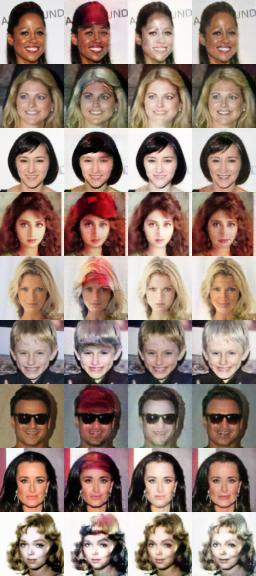

In [68]:
from IPython.display import Image, display

# Choose the iteration number of the saved model (both G, D should be present)
################################################
##### TODO CODE HERE
##### Load the trained model
##### Also, load the data_loader in test mode
G, D = restore_model(30000, config['model_save_dir'])
data_loader = get_loader(config, 'test')

################################################

with torch.no_grad():
    for i, (x_real, c_org) in enumerate(data_loader):

        # Prepare input images and target domain labels.
        x_real = x_real.to(config['device'])
        c_trg_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

        # Translate images.
        x_fake_list = [x_real]
        for c_trg in c_trg_list:
            x_fake = G(x_real, c_trg)
            x_fake_list.append(x_fake)

        # Save the translated images.
        x_concat = torch.cat(x_fake_list, dim=3)
        result_path = os.path.join( config['result_dir'], '{}-images.jpg'.format(i+1) )
        save_image(denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
        print('Saved real and fake images into {}...'.format(result_path))
        display(Image(filename=result_path))

In the bonus part, I select 3 attributes: Wearing_Hat, Pale_Skin, Young. I know these attributes are more complicated than 4.7. In order to gain a good training and testing results, I use 6 residual blocks and train 30000 times. The picture above is the result of 30000' model. We can get that the first output is attribute for Wearing_Hat, and there are some changes on head, which indicates the Hat. Maybe I should use some more useful architecture and proper parameters. While for second output, the pale skin, it shows a clear result. Every output face is pale than input image. This indicate my model is working well for this attribute. The last output is Young. It's same as Wearing_Hat, nothing changes a lot. In my opinion, I think these 2 attributes are too complicated, and I can't set some correct parameters without detail analysis. Maybe the architecture is not suitable for the attributes. I will do more in the future.